In [1]:
!where python

/bin/bash: line 1: where: command not found


# Load libraries

In [49]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from glob import glob
import os
from copy import deepcopy

import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Lorenz's libs
import math
import pandas as pd
import requests
from io import BytesIO
from pyproj import Proj, Transformer
import random
from tqdm import tqdm
import folium
from folium.plugins import MarkerCluster

# Define helper functions/classes

In [5]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

def convert_to_feed_model_func(RGB_image):

    sz0=RGB_image.shape[0]
    sz1=RGB_image.shape[1]

    train_imgs=np.zeros((sz0,sz1,2))
    train_input=np.zeros((sz0,sz1,1))

    ab=np.zeros((sz0,sz1,2))
    R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
    G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
    B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
    L, A, B = RGB2LAB2(R1,G1,B1)
    A = np.reshape(A,(sz0,sz1))
    B = np.reshape(B,(sz0,sz1))
    ab[:,:,0] = A
    ab[:,:,1] = B
    train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
    train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

    return (train_input, train_imgs)


In [6]:

####### Metrics #######


def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
 	return err

def rmse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
	err = np.sqrt(err)
	return err

# Define transforms


In [7]:
class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz0=img.shape[0]
        sz1=img.shape[1]

        train_imgs=np.zeros((sz0,sz1,2))
        train_input=np.zeros((sz0,sz1,1))

        ab=np.zeros((sz0,sz1,2))
        R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
        G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
        B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        A = np.reshape(A,(sz0,sz1))
        B = np.reshape(B,(sz0,sz1))
        ab[:,:,0] = A
        ab[:,:,1] = B
        train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
        train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
        return (train_input, train_imgs)

In [8]:
img_new_dim = 512
cent_crop_size = 350

# train_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=img_new_dim),
#         A.CenterCrop(height=cent_crop_size, width=cent_crop_size),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

# test_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=img_new_dim*2),
#         A.CenterCrop(height=cent_crop_size, width=cent_crop_size),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

train_transforms = transforms.Compose(
    [
        transforms.Resize(size=(img_new_dim, img_new_dim)),
        convert_RGB_to_feed_model()
        # transforms.Lambda(convert_to_feed_model),
        # v2.RandomHorizontalFlip(p=1),
        # v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    ]
)

# Download the raw data

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.

NOTE: the following are links stored in a private server, jet publically available

In [11]:
# raw_data_csv_file_link = "https://perritos.myasustor.com:3853/portal/apis/fileExplorer/download.cgi?act=download&link=EKxhA76k9&link_session_id=cDXOk9eeE9Es2a1JU1IOvA00&total=1&browser=firefox&mod_cntype=0&path=%2FRuben%2Fdatasets%2Ffetched_raw_imgs_via_api&file=metadata.csv"
raw_data_csv_file_link = "https://perritos.myasustor.com:1985/metadata.csv"
# only working locally
# raw_data_csv_file_link =
# "/Volumes/Ruben/datasets/fetched_raw_imgs_via_api/metadata.csv"

metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df

,img_id,img_name,latitude,longitude,zoom_level,class,link
0,0,3857_17_68545_45993,47.201780,8.264822,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
1,1,3857_16_34290_23041,47.032835,8.360899,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
2,2,3857_16_34497_22906,47.536282,9.500052,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3,3,3857_17_67996_46176,46.860006,6.759327,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
4,4,3857_17_68797_46090,47.021068,8.959244,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
...,...,...,...,...,...,...,...
3595,3595,3857_17_68680_46248,46.723525,8.635565,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3596,3596,3857_16_34412_23109,46.778972,9.030993,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3597,3597,3857_17_68885_46306,46.613634,9.199782,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3598,3598,3857_16_34489_23157,46.598598,9.455155,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....


In [15]:
metadata_raw_df.shape

(3600, 7)

# Create Train, Valid and Test sets

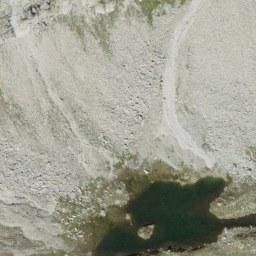

In [19]:
url = "https://perritos.myasustor.com:1985/data/img_id_10.jpg"
# url = "https://192.168.1.144:1985/data/img_id_0.jpg"
response = requests.get(url)
img_test = Image.open(BytesIO(response.content))
img_test

In [64]:
# create links to retrieve data
# list_of_links = [requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{i}.jpg") for i in range(metadata_raw_df.shape[0])]<

# list_of_images = []
# for i in tqdm(range(metadata_raw_df.shape[0])):
#   response = requests.get(url)
#   list_of_images.append(Image.open(BytesIO(response.content)))



In [63]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(len(x_train), len(x_val), len(x_test))

2700 540 360


In [58]:
len(x_test)

360

In [ ]:
# raw_data_dir = r"/Volumes/Ruben/datasets/raw_images"
# all_file_list = sorted(glob(os.path.join(raw_data_dir, "*.tif")))
# total_n_files = len(all_file_list)

# train_image_paths, valid_image_paths = all_file_list[:int(0.9*total_n_files)], all_file_list[int(0.9*total_n_files):]

# total_n_files_train = len(train_image_paths)
# train_image_paths, test_image_path = train_image_paths[:int(0.7*total_n_files)], train_image_paths[int(0.7*total_n_files):]

# print(f"Train size: {len(train_image_paths)}\nValidation size: {len(valid_image_paths)}\nTest size {len(test_image_path)}")

Train size: 350
Validation size: 50
Test size 100


In [ ]:
# path_to_save_raw_images = r"/Volumes/Ruben/datasets/fetched_data_again"
# jpg_files = sorted(glob(os.path.join(path_to_save_raw_images, "*", "*.jpg")))
# len(jpg_files)

3595

In [ ]:
jpg_files[:10]

['/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_33868_23254.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_33893_23263.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_33908_23203.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34007_23117.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34052_23158.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34094_22954.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34114_23065.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34124_23026.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34137_23005.jpg',
 '/Volumes/Ruben/datasets/fetched_data_again/data/ImageId_class10_3857_16_34142_22915.jpg']

# Create a Dataset class

In [39]:
# class Swisstopodataset(Dataset):
#     def __init__(self, image_path, transform = False):
#         self.image_path = image_path
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_path)

#     def __getitem__(self, idx):
#         img_filepath  = self.image_path[idx]
#         image = cv2.imread(img_filepath)
#         image = Image.fromarray(image)

#         # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # define here a label if existing

#         if self.transform is not None:
#             image = self.transform(image)

#         return image


In [40]:
class Swisstopodataset(Dataset):
    def __init__(self, img_indx, transform = False):
        self.img_indx = img_indx
        self.transform = transform

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing

        if self.transform is not None:
            image = self.transform(image)

        return image


In [62]:
train_dataset = Swisstopodataset(x_train, transform=train_transforms)
valid_dataset = Swisstopodataset(x_val, transform=train_transforms) #test transforms are applied
test_dataset = Swisstopodataset(x_test, transform=train_transforms)

print(f"The shape of tensor for 50th image in train dataset of channel L is :{train_dataset[49][0].shape}\nand of channel AB is :{train_dataset[49][1].shape}")


The shape of tensor for 50th image in train dataset of channel L is :(512, 512, 1)
and of channel AB is :(512, 512, 2)


# visualize the datasets (images)

In [ ]:
def visualize_dataset(dataset, samples = 10, cols = 5, random_img = False):
    dataset = deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols

    figure, ax = plt.subplots(nrows= rows, ncols = cols, figsize = (12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(train_image_paths))
        image = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Img indx {i}")
    plt.tight_layout(pad=1)
    plt.show()

In [ ]:
train_dataset.__len__()

350

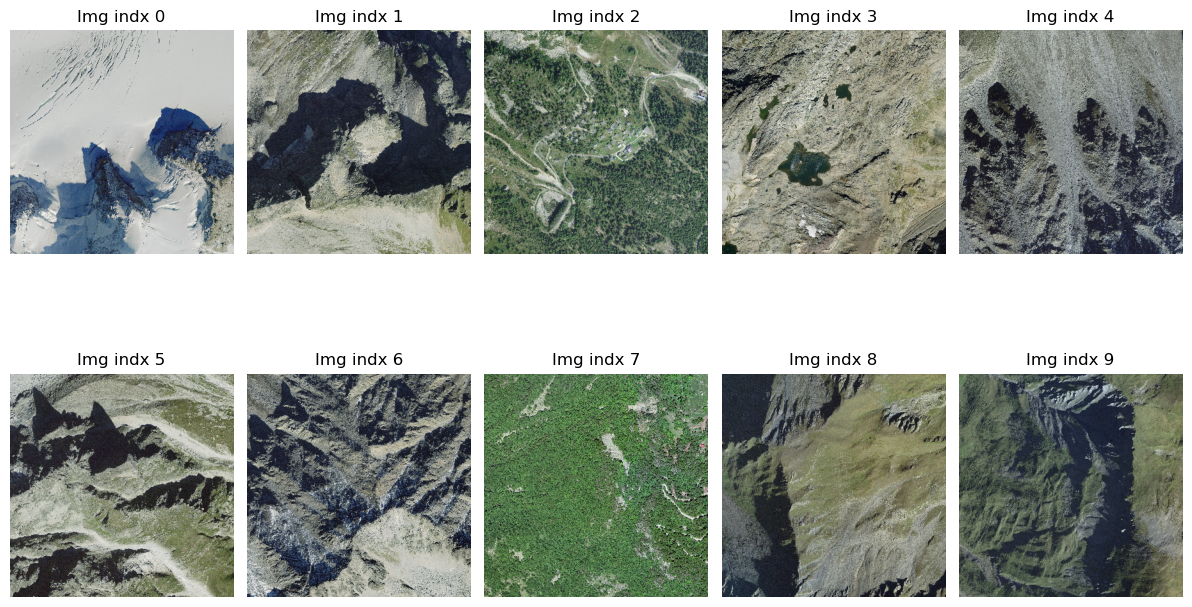

In [ ]:
visualize_dataset(train_dataset, random_img= True)

# Creating a DataLoader

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [ ]:
#batch of image tensor
next(iter(train_loader)).shape


torch.Size([64, 3, 350, 350])

In [ ]:
next(iter(train_loader))[1].shape